# Electrophysiology Pipeline

This tutorial builds an electrophysiology analysis pipeline using DataJoint. You'll learn to:

- **Import** neural recordings from data files
- **Compute** activity statistics
- **Detect spikes** using parameterized thresholds
- **Extract waveforms** using Part tables

## The Pipeline

<img src="/images/ephys-pipeline.svg" alt="Electrophysiology Pipeline" width="600">

**Legend:** Green = Manual, Gray = Lookup, Blue = Imported, Red = Computed, White = Part

Each session records from neurons. We compute statistics, detect spikes with configurable thresholds, and extract spike waveforms.

## Setup

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

schema = dj.Schema('tutorial_electrophysiology')

# Data directory (relative to this notebook)
DATA_DIR = Path('./data')

[2026-02-19 18:32:53] DataJoint 2.1.1 connected to postgres@postgres:5432


## Manual Tables: Experiment Metadata

In [2]:
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int32
    ---
    dob : date
    sex : enum('M', 'F', 'unknown')
    """


@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_date : date
    ---
    experimenter : varchar(100)
    """

### Insert Sample Data

Our data files follow the naming convention `data_{mouse_id}_{session_date}.npy`.

In [3]:
# Insert mice
Mouse.insert([
    {'mouse_id': 0, 'dob': '2017-03-01', 'sex': 'M'},
    {'mouse_id': 5, 'dob': '2016-12-25', 'sex': 'F'},
    {'mouse_id': 100, 'dob': '2017-05-12', 'sex': 'F'},
], skip_duplicates=True)

# Insert sessions (matching our data files)
Session.insert([
    {'mouse_id': 0, 'session_date': '2017-05-15', 'experimenter': 'Alice'},
    {'mouse_id': 0, 'session_date': '2017-05-19', 'experimenter': 'Alice'},
    {'mouse_id': 5, 'session_date': '2017-01-05', 'experimenter': 'Bob'},
    {'mouse_id': 100, 'session_date': '2017-05-25', 'experimenter': 'Carol'},
    {'mouse_id': 100, 'session_date': '2017-06-01', 'experimenter': 'Carol'},
], skip_duplicates=True)

Session()

mouse_id,session_date,experimenter
0,2017-05-15,Alice
0,2017-05-19,Alice
5,2017-01-05,Bob
100,2017-05-25,Carol
100,2017-06-01,Carol


## Imported Table: Neuron Activity

Each data file contains recordings from one or more neurons. We import each neuron's activity trace.

In [4]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id : int16
    ---
    activity : <blob>    # neural activity trace
    """

    def make(self, key):
        # Construct filename from key
        filename = f"data_{key['mouse_id']}_{key['session_date']}.npy"
        filepath = DATA_DIR / filename
        
        # Load data (shape: n_neurons x n_timepoints)
        data = np.load(filepath)
        
        # Insert one row per neuron
        for neuron_id, activity in enumerate(data):
            self.insert1({
                **key,
                'neuron_id': neuron_id,
                'activity': activity
            })
        
        print(f"Imported {len(data)} neuron(s) from {filename}")

In [5]:
Neuron.populate(display_progress=True)

Neuron:   0%|          | 0/5 [00:00<?, ?it/s]

Neuron: 100%|██████████| 5/5 [00:00<00:00, 380.61it/s]

Imported 1 neuron(s) from data_0_2017-05-15.npy
Imported 1 neuron(s) from data_0_2017-05-19.npy
Imported 1 neuron(s) from data_5_2017-01-05.npy
Imported 1 neuron(s) from data_100_2017-05-25.npy
Imported 1 neuron(s) from data_100_2017-06-01.npy


{'success_count': 5, 'error_list': []}

In [6]:
Neuron()

mouse_id,session_date,neuron_id,activity
0,2017-05-15,0,<blob>
0,2017-05-19,0,<blob>
5,2017-01-05,0,<blob>
100,2017-05-25,0,<blob>
100,2017-06-01,0,<blob>


### Visualize Neural Activity

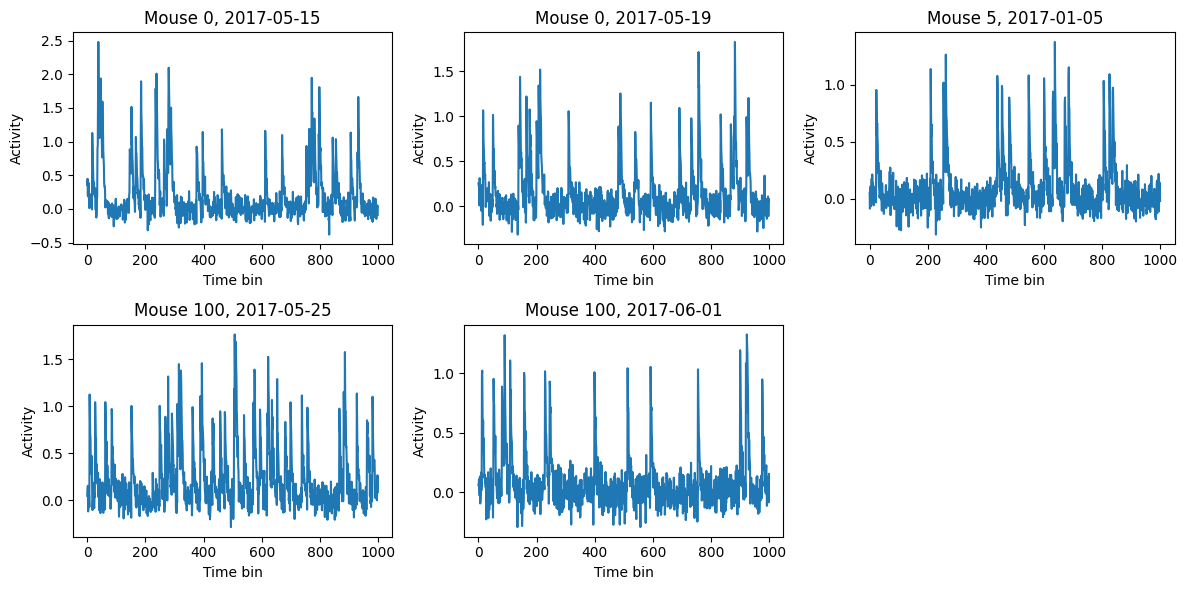

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ax, key in zip(axes.ravel(), Neuron.keys()):
    activity = (Neuron & key).fetch1('activity')
    ax.plot(activity)
    ax.set_title(f"Mouse {key['mouse_id']}, {key['session_date']}")
    ax.set_xlabel('Time bin')
    ax.set_ylabel('Activity')

# Hide unused subplot
axes[1, 2].axis('off')
plt.tight_layout()

## Computed Table: Activity Statistics

For each neuron, compute basic statistics of the activity trace.

In [8]:
@schema
class ActivityStats(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean_activity : float32
    std_activity : float32
    max_activity : float32
    """

    def make(self, key):
        activity = (Neuron & key).fetch1('activity')
        
        self.insert1({
            **key,
            'mean_activity': activity.mean(),
            'std_activity': activity.std(),
            'max_activity': activity.max()
        })

In [9]:
ActivityStats.populate(display_progress=True)
ActivityStats()

ActivityStats:   0%|          | 0/5 [00:00<?, ?it/s]

ActivityStats: 100%|██████████| 5/5 [00:00<00:00, 1178.51it/s]

mouse_id,session_date,neuron_id,mean_activity,std_activity,max_activity
0,2017-05-15,0,0.20735653,0.40086678,2.481606
0,2017-05-19,0,0.1327401,0.2914616,1.8280541
5,2017-01-05,0,0.089178555,0.23641196,1.3738891
100,2017-05-25,0,0.21906962,0.32878324,1.7638324
100,2017-06-01,0,0.08732656,0.23785825,1.324542


## Lookup Table: Spike Detection Parameters

Spike detection depends on threshold choice. Using a Lookup table, we can run detection with multiple thresholds and compare results.

In [10]:
@schema
class SpikeParams(dj.Lookup):
    definition = """
    spike_param_id : int16
    ---
    threshold : float32    # spike detection threshold
    """
    
    contents = [
        {'spike_param_id': 1, 'threshold': 0.5},
        {'spike_param_id': 2, 'threshold': 0.9},
    ]

SpikeParams()

spike_param_id,threshold
1,0.5
2,0.9


## Computed Table with Part Table: Spike Detection

Detect spikes by finding threshold crossings. Store:
- **Master table**: spike count and binary spike array
- **Part table**: waveform for each spike

In [11]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeParams
    ---
    spike_times : <blob>    # indices of detected spikes
    spike_count : int32     # total number of spikes
    """

    class Waveform(dj.Part):
        definition = """
        -> master
        spike_idx : int32
        ---
        waveform : <blob>    # activity around spike (±40 samples)
        """

    def make(self, key):
        # Fetch inputs
        activity = (Neuron & key).fetch1('activity')
        threshold = (SpikeParams & key).fetch1('threshold')
        
        # Detect threshold crossings (rising edge)
        above_threshold = (activity > threshold).astype(int)
        rising_edge = np.diff(above_threshold) > 0
        spike_times = np.where(rising_edge)[0] + 1  # +1 to get crossing point
        
        # Insert master entry
        self.insert1({
            **key,
            'spike_times': spike_times,
            'spike_count': len(spike_times)
        })
        
        # Extract and insert waveforms
        window = 40  # samples before and after spike
        for spike_idx, t in enumerate(spike_times):
            # Skip spikes too close to edges
            if t < window or t >= len(activity) - window:
                continue
            
            waveform = activity[t - window : t + window]
            self.Waveform.insert1({
                **key,
                'spike_idx': spike_idx,
                'waveform': waveform
            })

In [12]:
Spikes.populate(display_progress=True)

Spikes:   0%|          | 0/10 [00:00<?, ?it/s]

Spikes: 100%|██████████| 10/10 [00:00<00:00, 272.33it/s]

{'success_count': 10, 'error_list': []}

In [13]:
# View spike counts for each neuron × parameter combination
Spikes.proj('spike_count')

mouse_id,session_date,neuron_id,spike_param_id,spike_count
0,2017-05-15,0,1,26
0,2017-05-15,0,2,27
0,2017-05-19,0,1,24
0,2017-05-19,0,2,21
5,2017-01-05,0,1,18
5,2017-01-05,0,2,14
100,2017-05-25,0,1,41
100,2017-05-25,0,2,35
100,2017-06-01,0,1,18
100,2017-06-01,0,2,15


### Compare Detection Thresholds

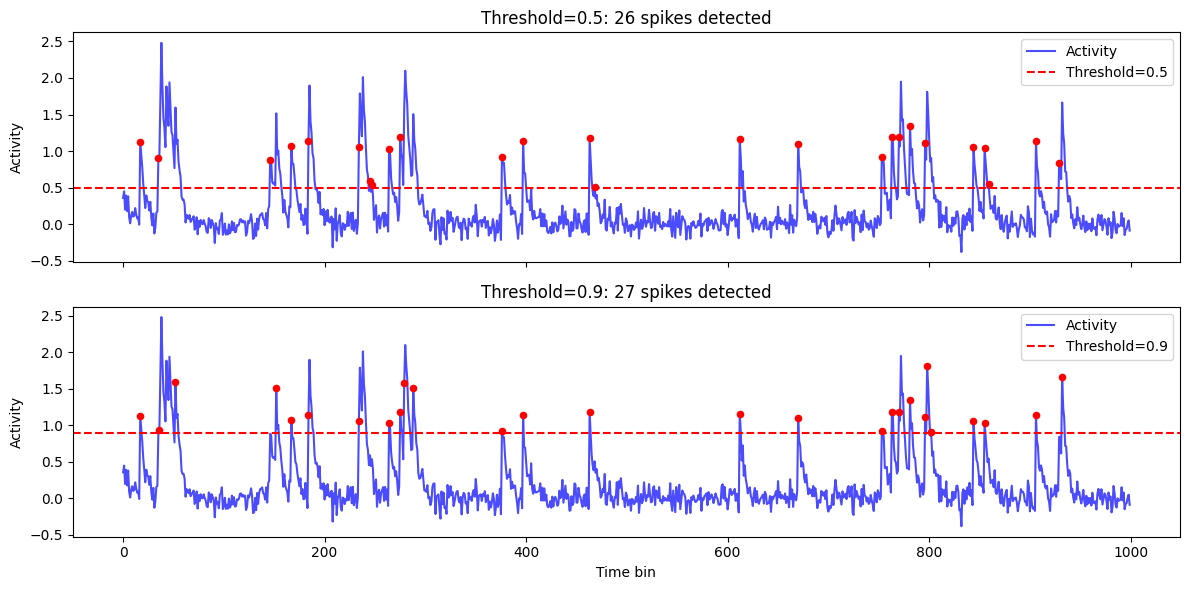

In [14]:
# Pick one neuron to visualize
neuron_key = {'mouse_id': 0, 'session_date': '2017-05-15', 'neuron_id': 0}
activity = (Neuron & neuron_key).fetch1('activity')

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for ax, param_id in zip(axes, [1, 2]):
    key = {**neuron_key, 'spike_param_id': param_id}
    spike_times, spike_count = (Spikes & key).fetch1('spike_times', 'spike_count')
    threshold = (SpikeParams & {'spike_param_id': param_id}).fetch1('threshold')
    
    ax.plot(activity, 'b-', alpha=0.7, label='Activity')
    ax.axhline(threshold, color='r', linestyle='--', label=f'Threshold={threshold}')
    ax.scatter(spike_times, activity[spike_times], color='red', s=20, zorder=5)
    ax.set_title(f'Threshold={threshold}: {spike_count} spikes detected')
    ax.set_ylabel('Activity')
    ax.legend(loc='upper right')

axes[1].set_xlabel('Time bin')
plt.tight_layout()

### Average Waveform

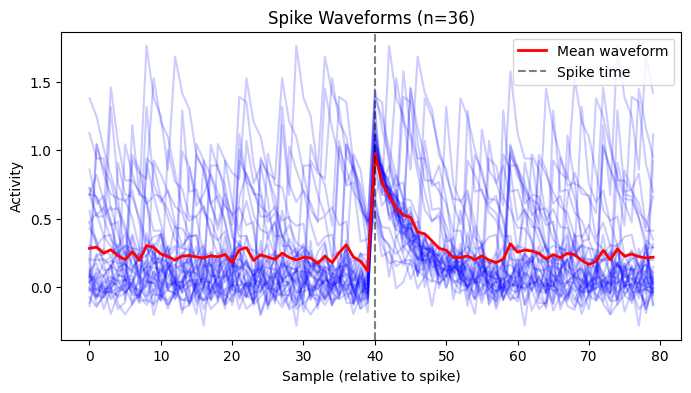

In [15]:
# Get waveforms for one neuron with threshold=0.5
key = {'mouse_id': 100, 'session_date': '2017-05-25', 'neuron_id': 0, 'spike_param_id': 1}
waveforms = (Spikes.Waveform & key).to_arrays('waveform')

if len(waveforms) > 0:
    waveform_matrix = np.vstack(waveforms)
    
    plt.figure(figsize=(8, 4))
    # Plot individual waveforms (light)
    for wf in waveform_matrix:
        plt.plot(wf, 'b-', alpha=0.2)
    # Plot mean waveform (bold)
    plt.plot(waveform_matrix.mean(axis=0), 'r-', linewidth=2, label='Mean waveform')
    plt.axvline(40, color='k', linestyle='--', alpha=0.5, label='Spike time')
    plt.xlabel('Sample (relative to spike)')
    plt.ylabel('Activity')
    plt.title(f'Spike Waveforms (n={len(waveforms)})')
    plt.legend()
else:
    print("No waveforms found for this key")

## Pipeline Diagram

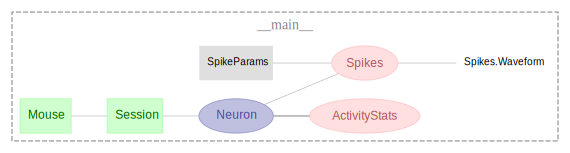

In [16]:
dj.Diagram(schema)

## Querying Results

DataJoint makes it easy to query across the pipeline.

In [17]:
# Find neurons with high spike counts (threshold=0.5)
(Spikes & 'spike_param_id = 1' & 'spike_count > 20').proj('spike_count')

mouse_id,session_date,neuron_id,spike_param_id,spike_count
0,2017-05-15,0,1,26
0,2017-05-19,0,1,24
100,2017-05-25,0,1,41


In [18]:
# Join with Mouse to see which mice have most spikes
(Mouse * Session * Spikes & 'spike_param_id = 1').proj('spike_count')

mouse_id,session_date,neuron_id,spike_param_id,spike_count
0,2017-05-15,0,1,26
0,2017-05-19,0,1,24
5,2017-01-05,0,1,18
100,2017-05-25,0,1,41
100,2017-06-01,0,1,18


## Summary

This pipeline demonstrates key patterns for electrophysiology analysis:

| Concept | Example | Purpose |
|---------|---------|--------|
| **Imported tables** | `Neuron` | Load data from files |
| **Computed tables** | `ActivityStats`, `Spikes` | Derive results |
| **Lookup tables** | `SpikeParams` | Parameterize analysis |
| **Part tables** | `Waveform` | Store variable-length results |
| **Multi-parent keys** | `Spikes` | Compute all Neuron × Param combinations |

### Key Benefits

1. **Parameter comparison**: Different thresholds stored alongside results
2. **Automatic tracking**: `populate()` knows what's computed vs. pending
3. **Cascading**: Delete a parameter set, all derived results cascade
4. **Provenance**: Trace any spike back to its source recording

In [19]:
# Cleanup: drop schema for re-running
schema.drop(prompt=False)